# An infinite dataset of images with random lines, curves and ellipses

## Imports

In [1]:
import writefile_run

In [2]:
%%writefile_run lines_curves_dataset.py


"""Dataset which generates images with random lines and curves"""

import torch
from torch.utils.data import *
import skimage.draw as d
from skimage.filters import gaussian
import numpy as np
from numpy.random import *
from scipy.ndimage.morphology import *

In [3]:
from pylab import *

In [4]:
style.use('dark_background')

# Helper functions to add lines and curves to an image

In [5]:
%%writefile_run lines_curves_dataset.py -a


def addLine(img, x_range=(0,64), y_range=(0,64), val=1, dil_range=(2,4), shape=(64,64)):
    """Adds a random line to img, which could be a 2D numpy array or torch tensor.
    Mutates the input img.
    
    Arguments
    ---------
    x_range: The range over x values which line endpoints can take
    y_range: The range over y values which line endpoints can take
    val: The value to fill at points on the added line
    shape: The shape of the image to truncate the curve if it exceeds the limits
    dil_range: The range of kernel sizes to randomly choose between for dilating the
        drawn object. Effectively corresponds to stroke width.
    """
    r,c = d.line(randint(*x_range),randint(*y_range),
                 randint(*x_range),randint(*y_range))
    
    temp_img = np.zeros(shape)
    temp_img[r,c]=val
    
    dilate_size = np.random.randint(*dil_range)
    temp_img = grey_dilation(temp_img,size=(dilate_size,dilate_size))
    
    img[np.where(temp_img==val)]=val
    
    return img

In [6]:
%%writefile_run lines_curves_dataset.py -a


def addCurve(img,x_range=(0,64),y_range=(0,64),val=1,dil_range=(2,4),shape=(64,64)):
    """Adds a random line to img, which could be a 2D numpy array or torch tensor.
    Mutates the input img.
    
    Arguments
    ---------
    x_range: The range over x values which the control points can take
    y_range: The range over y values which the control points can take
    val: The value to fill at points on the added line
    shape: The shape of the image to truncate the curve if it exceeds the limits
    dil_range: The range of kernel sizes to randomly choose between for dilating the
        drawn object. Effectively corresponds to stroke width.
    """
    r,c = d.bezier_curve(randint(*x_range),randint(*y_range),
                           randint(*x_range),randint(*y_range),
                           randint(*x_range),randint(*y_range),
                           1,shape=shape)
    
    temp_img = np.zeros(shape)
    temp_img[r,c]=val
    
    dilate_size = np.random.randint(*dil_range)
    temp_img = grey_dilation(temp_img,size=(dilate_size,dilate_size))
    
    img[np.where(temp_img==val)]=val
    
    return img

In [7]:
%%writefile_run lines_curves_dataset.py -a


def addEllipse(img, x_range=(0,64),y_range=(0,64),val=1,dil_range=(2,4),shape=(64,64)):
    """Adds a random ellipse to img, which could be a 2D numpy array or torch tensor.
    Mutates the input img.
    
    Arguments
    ---------
    x_range: The range over x values which line endpoints can take
    y_range: The range over y values which line endpoints can take
    val: The value to fill at points on the added line
    shape: The shape of the image to truncate the curve if it exceeds the limits
    dil_range: The range of kernel sizes to randomly choose between for dilating the
        drawn object. Effectively corresponds to stroke width.
    """
    xdiff = x_range[1]-x_range[0]
    ydiff = y_range[1]-y_range[0]
    max_r = min(xdiff,ydiff)/2
    r,c = d.ellipse_perimeter(randint(*x_range),randint(*y_range),
                 randint(max_r/4,max_r),randint(max_r/4,max_r),orientation=random()*np.pi,
                             shape=shape)
    temp_img = np.zeros(shape)
    temp_img[r,c]=val
    
    dilate_size = np.random.randint(*dil_range)
    temp_img = grey_dilation(temp_img,size=(dilate_size,dilate_size))
    
    img[np.where(temp_img==val)]=val
    
    return img

## Example

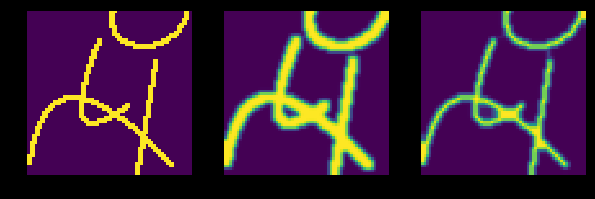

In [8]:
im = torch.zeros(size=(64,64)).numpy()
addLine(im)
addCurve(im)
addCurve(im)
addEllipse(im)
subplots(1,2,figsize=(10,10))

subplot(1,3,1)
axis('off')
imshow(im)

subplot(1,3,2)
axis('off')
im = grey_dilation(im,size=(3,3))
im = gaussian(im,sigma=0.7)
imshow(im)
im = grey_erosion(im,size=(3,3))

subplot(1,3,3)
axis('off')
imshow(im)
show()

# The dataset class

In [9]:
%%writefile_run lines_curves_dataset.py -a


class LinesCurvesDataset(Dataset):
    def __init__(self, imgs_per_epoch = 5000,
                 nlines_range=(1,2),ncurves_range=(1,2),nellipses_range=(1,2),
                 x_range=(0,64),y_range=(0,64),dilation_size_range=(2,4),
                 img_size=(64,64),blur_sigma=0.7,
                 transform=None,
                 device=torch.device('cuda')):
        """A dataset which generates images with random lines and curves
        
        Arguments
        ---------
        imgs_per_epoch: A number signifying how many images to be generated in an epoch.
        It is equal to the length of this dataset.
        
        nlines_range, ncurves_range, nellipses_range: The range of number(random) of lines and curves 
            in the image given by (low,high), with low inclusive and high exclusive.
        
        x_range, y_range: The range of x and y coordinates(random) in the image which
            can be endpoints or control points of the lines or curves.
        
        dilation_size_range The range of kernel size(random) for grey_dilation to expand strokes.
        
        img_size: The size of each image.
        
        blur_sigma: The standard deviation of the gaussian blur applied after adding the
            lines and curves.
            
        device: The torch device of the tensor returned.
        
        Each image has shape (1,*img_size)
        """
        
        self.imgs_per_epoch = imgs_per_epoch
        self.nlines_range = nlines_range
        self.ncurves_range = ncurves_range
        self.nellipses_range = nellipses_range
        self.x_range = x_range
        self.y_range = y_range
        self.dilation_size_range = dilation_size_range
        self.img_size = img_size
        self.blur_sigma = blur_sigma
        self.device = device
        self.transform = transform
        
    def __len__(self):
        return self.imgs_per_epoch
    
    def __getitem__(self,i):
        
        # init image
        im = np.zeros(self.img_size)
        
        # Add lines
        nlines = np.random.randint(*self.nlines_range)
        for a in range(nlines):
            addLine(im, 
                    x_range=self.x_range, 
                    y_range=self.y_range, 
                    dil_range=self.dilation_size_range,
                    shape=self.img_size)
        
        # Add curves
        ncurves = np.random.randint(*self.ncurves_range)
        for a in range(ncurves):
            addCurve(im, 
                     x_range=self.x_range, 
                     y_range=self.y_range, 
                     dil_range=self.dilation_size_range, 
                     shape=self.img_size)
        
        # Add ellipses
        nellipses = np.random.randint(*self.nellipses_range)
        for a in range(nellipses):
            addEllipse(im, 
                       x_range=self.x_range, 
                       y_range=self.y_range, 
                       dil_range=self.dilation_size_range, 
                       shape=self.img_size)

        # blur
        im = gaussian(im,sigma=self.blur_sigma)

        # convert to tensor
        im = torch.tensor(im,dtype=torch.float32,device=self.device)
        
        # reshape
        im = im.view(1,*self.img_size)
        
        # transform if given
        if self.transform != None:
            im = self.transform(im)
        
        return im
    
    def __str__(self):
        var_names = '\n'.join([f'{k} = {v}' for k,v in self.__dict__.items()])
        return f"{self.__class__}\n{var_names}"

## Example usage of dataset

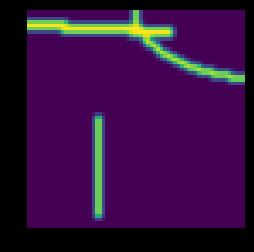

In [10]:
test_dset = LinesCurvesDataset()
im = test_dset[0]
axis('off')
imshow(im.squeeze())

In [11]:
print(str(test_dset))

<class '__main__.LinesCurvesDataset'>
imgs_per_epoch = 5000
nlines_range = (1, 2)
ncurves_range = (1, 2)
nellipses_range = (1, 2)
x_range = (0, 64)
y_range = (0, 64)
dilation_size_range = (2, 4)
img_size = (64, 64)
blur_sigma = 0.7
device = cuda
transform = None
